In [ ]:
! pip install -r requirements.txt

In [1]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import json # for dumping debug data
import time # for benchmarking
import numpy as np
from ddqn_torch import DoubleQAgent

LEARN_EVERY = 4
def train_agent(n_episodes=2000, load_latest_model=False):
    print("Training a DDQN agent on {} episodes. Pretrained model = {}".format(n_episodes,load_latest_model))
    env = gym.make("LunarLander-v2")
    agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.995, lr=0.001, mem_size=200000, batch_size=128, epsilon_end=0.01)
    if load_latest_model:
        agent.load_saved_model('ddqn_torch_model.h5')
        print('Loaded most recent: ddqn_torch_model.h5')
        
    scores = []
    eps_history = []
    start = time.time()
    for i in range(n_episodes):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            agent.save(state, action, reward, new_state, terminated)
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
            steps += 1
            score += reward
            
        eps_history.append(agent.epsilon)
        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])

        if (i+1) % 10 == 0 and i > 0:
            # Report expected time to finish the training
            print('Episode {} in {:.2f} min. Expected total time for {} episodes: {:.0f} min. [{:.2f}/{:.2f}]'.format((i+1), 
                                                                                                                      (time.time() - start)/60, 
                                                                                                                      n_episodes, 
                                                                                                                      (((time.time() - start)/i)*n_episodes)/60, 
                                                                                                                      score, 
                                                                                                                      avg_score))
            
        if (i+1) % 100 == 0 and i > 0:
            # Save the model every N-th step just in case
            agent.save_model('ddqn_torch_model.h5')
            with open("ddqn_torch_dqn_scores_{}.json".format(int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("ddqn_torch_eps_history_{}.json".format(int(time.time())), "w") as fp:
                json.dump(eps_history, fp)
                
    return agent

In [2]:
# Uncomment to train
# agent = train_agent(n_episodes=1500, load_latest_model=False)

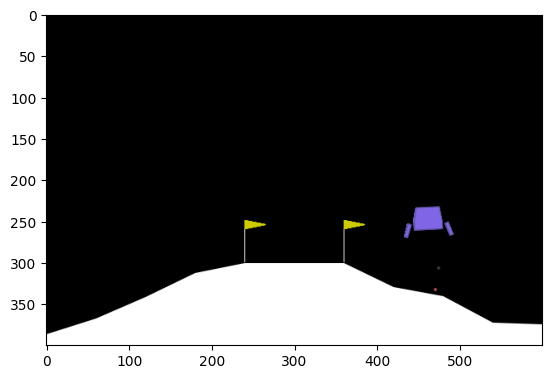

In [3]:
# Visualize the model
import gymnasium as gym
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Set path to the model to visualize
model_to_animate = 'stats/mu.h5'

def animate_model(name, atype='single'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = DoubleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=200000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset(seed=12)
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            clear_output(wait=True)
            plt.imshow( env.render() )
            plt.show()
        state = env.reset()[0]
    env.close()

animate_model(model_to_animate, atype='double')